In [1]:
# !pip install tensorflow

!pip install numpy==1.26.4 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/MyDrive/data_kidney.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (3123).jpg  
  inflating: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (3124).jpg  
  inflating: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (3125).jpg  
  inflating: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (3126).jpg  
  inflating: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (3127).jpg  
  inflating: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (3128).jpg  
  inflating: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]], dtype=uint8)
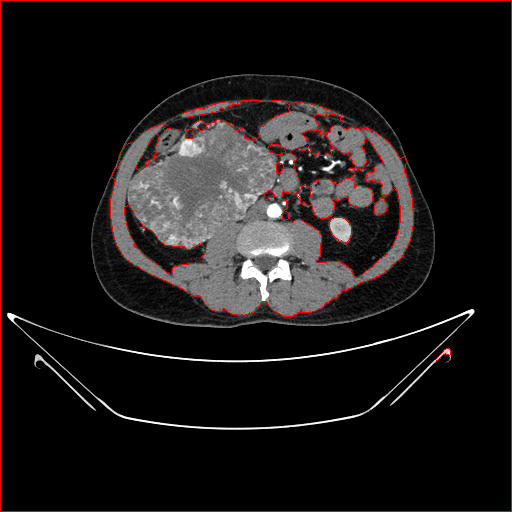

In [4]:
#Watershed function
import cv2 as cv
import numpy as np
def watershed(image_path):
    img = cv.imread(image_path)

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.001*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)



# Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0


    markers = cv.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Mark boundaries in red

    return img

segmented_img = watershed('/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (101).jpg')
segmented_img









In [5]:
## For saving the preprocess image
import os
def process_and_save_images(src_dir, dest_dir):
    # Create the destination folders if they don't exist
    normal_dir = os.path.join(dest_dir, 'Normal')
    tumor_dir = os.path.join(dest_dir, 'Tumor')

    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(tumor_dir, exist_ok=True)

    # Loop over images in the "Normal" and "Tumor" folders
    for folder_name in ['Normal', 'Tumor']:
        folder_path = os.path.join(src_dir, folder_name)
        output_folder = normal_dir if folder_name == 'Normal' else tumor_dir

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)

            if os.path.isfile(file_path):
                # Apply the watershed function
                processed_img = watershed(file_path)

                # Construct the output file path
                output_file_path = os.path.join(output_folder, filename)

                # Save the processed image
                cv.imwrite(output_file_path, processed_img)
                print(f"Processed and saved: {output_file_path}")


# Define the source and destination directories
src_directory = '/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
dest_directory = '/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess'

# Process and save images
process_and_save_images(src_directory, dest_directory)

Streaming output truncated to the last 5000 lines.
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (3698).jpg
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (4358).jpg
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (3445).jpg
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (3418).jpg
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (2577).jpg
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (2312).jpg
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (2645).jpg
Processed and saved: /content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess/Normal/Normal- (765).jpg
Processed and 

In [6]:
! pip install python_splitter


In [7]:
# Train Test Splitter
import python_splitter
python_splitter.split_from_folder("/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/preprocess", train=0.8,test=0.2)


✅Checking SOURCE directory...
0.8 0 0.2
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [8]:
#Counting the data
import os

def count_images(base_dir):
    categories = ['Normal', 'Tumor']
    data_counts = {}

    for split in ['train', 'test']:
        split_path = os.path.join(base_dir, split)
        data_counts[split] = {}

        for category in categories:
            category_path = os.path.join(split_path, category)
            if os.path.exists(category_path):
                data_counts[split][category] = len(os.listdir(category_path))
            else:
                data_counts[split][category] = 0  # If folder doesn't exist

    return data_counts


# Path to the Train_Test_Folder
base_directory = "/content/Train_Test_Folder"

# Get counts
counts = count_images(base_directory)

# Print results
for split, categories in counts.items():
    print(f"\n#### {split} Data ####")
    for category, count in categories.items():
        print(f"{category}: {count} images")



#### train Data ####
Normal: 4061 images
Tumor: 1826 images

#### test Data ####
Normal: 1016 images
Tumor: 457 images


In [9]:
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 43.8 MB/s eta 0:00:00


In [10]:
#Augmenting the data
import cv2
import imgaug.augmenters as iaa
import numpy as np
import random
import os

def augment_and_save_images(folder_path):
    """
    Augments all images in the specified folder and saves the augmented images in the same folder.
    """
    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("No images found in the specified folder.")
        return

    print(f"Found {len(image_files)} images. Augmenting...")

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to read {image_file}")
            continue

        # Define augmentation sequence
        augmenters = [
            iaa.Affine(rotate=(-15, 15)),  # Rotation
            iaa.Fliplr(0.8),  # Horizontal flip
            iaa.Flipud(0.8),  # Vertical flip
            iaa.Affine(translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}),  # Width & height shift
            iaa.Affine(shear=(-5, 5)),  # Shear transformation
            iaa.Affine(scale=(0.8, 1.2)),  # Zoom in/out (80%-120%)
            iaa.Multiply((0.5, 1.5))  # Brightness change
        ]

        # Randomly select 4-6 augmentations
        selected_augmenters = random.sample(augmenters, random.randint(4, 6))

        # Apply augmentations
        seq = iaa.Sequential(selected_augmenters)
        augmented_image = seq.augment_image(image)

        # Generate new filename
        augmented_image_name = f"aug_{image_file}"
        augmented_image_path = os.path.join(folder_path, augmented_image_name)

        # Save the augmented image
        cv2.imwrite(augmented_image_path, augmented_image)
        print(f"Saved: {augmented_image_path}")

    print("Augmentation complete.")

# Example usage
folder_path = "/content/Train_Test_Folder/train/Tumor"  # Update with your actual path
augment_and_save_images(folder_path)


Found 1826 images. Augmenting...
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1709).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1055).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (461).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1898).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (486).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1825).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1181).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1037).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (506).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1060).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (235).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1552).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (1656).jpg
Saved: /content/Train_Test_Folder/train/Tumor/aug_Tumor- (43).jpg
Saved: /content/Train

In [11]:
####VGG -16 ###############
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow import keras



# Check if GPUs are available
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

# Create a MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Create and compile the model inside the strategy scope
with strategy.scope():
    # Define the base VGG16 model without the top layers
    base_model = tf.keras.applications.VGG16(
        input_shape=(224, 224, 3),
        weights="imagenet",  # Correct way to initialize the model without pre-trained weights
        include_top=False
    )

    base_model.trainable = False  # Freeze the base model layers

    # Add custom layers on top of the base model with L2 regularization
    flatten_in = tf.keras.layers.Flatten()(base_model.output)

    fc1 = tf.keras.layers.Dense(
        1024,
        activation="relu",
        # kernel_regularizer=regularizers.l2(0.01)  # Apply L2 regularization with lambda=0.01
    )(flatten_in)

    fc2 = tf.keras.layers.Dense(
        512,
        activation="relu",
        # kernel_regularizer=regularizers.l2(0.01)  # Apply L2 regularization with lambda=0.01
    )(fc1)

    prediction = tf.keras.layers.Dense(
        units=2,
        activation="softmax",
        # kernel_regularizer=regularizers.l2(0.01)  # Apply L2 regularization with lambda=0.01
    )(fc2)

    # Create the final model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

# Model summary
model.summary()

# If you have your data generators set up (train_generator and valid_generator)
# You can now train the model using model.fit() as usual.


Num GPUs Available: 1
Number of devices: 1
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,931,650 (156.14 MB)

 Trainable params: 26,216,962 (100.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
#New
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

# Common preprocessing function (VGG16 normalization)
datagenerator_kwargs = dict(
    preprocessing_function=preprocess_input,
)

# Common data flow parameters
dataflow_kwargs = dict(
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=128,
    interpolation="bilinear"  # Image resizing interpolation method
)

# Validation data generator (NO Augmentations)
valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagenerator_kwargs
)

valid_generator = valid_datagenerator.flow_from_directory(
    directory='/content/Train_Test_Folder/test',  # Using 'test' as validation data
    shuffle=False,
    **dataflow_kwargs
)

# Training data generator (With Augmentations)
train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,  # Wider rotation range
    vertical_flip=True,
    horizontal_flip=True,
    width_shift_range=0.1,  # Slightly larger shift range
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.3,  # Increased zoom range
    brightness_range=[0.3, 1.7],  # Increased brightness range
    **datagenerator_kwargs
)

train_generator = train_datagenerator.flow_from_directory(
    directory='/content/Train_Test_Folder/train',  # Training dataset
    shuffle=True,
    **dataflow_kwargs
)


Found 1473 images belonging to 2 classes.
Found 7713 images belonging to 2 classes.


In [13]:
# Get a batch of images and labels
batch_images, batch_labels = next(iter(train_generator))

# Print the shape of the batch
print(batch_images.shape)  # Expected output: (batch_size, 224, 224, 3)


(128, 224, 224, 3)


In [14]:
# Get the number of samples for each class in the training set
train_class_counts = train_generator.class_indices
print(f"Training class indices: {train_class_counts}")

# Efficiently count samples per class in the training set
train_class_counts = {class_name: 0 for class_name in train_generator.class_indices.keys()}
for class_name, class_index in train_generator.class_indices.items():
    train_class_counts[class_name] = sum(train_generator.classes == class_index)

print(f"Training data class distribution: {train_class_counts}")

# Get the number of samples for each class in the validation set
valid_class_counts = valid_generator.class_indices
print(f"Validation class indices: {valid_class_counts}")

# Efficiently count samples per class in the validation set
valid_class_counts = {class_name: 0 for class_name in valid_generator.class_indices.keys()}
for class_name, class_index in valid_generator.class_indices.items():
    valid_class_counts[class_name] = sum(valid_generator.classes == class_index)

print(f"Validation data class distribution: {valid_class_counts}")


Training class indices: {'Normal': 0, 'Tumor': 1}
Training data class distribution: {'Normal': 4061, 'Tumor': 3652}
Validation class indices: {'Normal': 0, 'Tumor': 1}
Validation data class distribution: {'Normal': 1016, 'Tumor': 457}


In [17]:
#Early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_accuracy", patience=6
)

In [18]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a directory to save the model if it doesn't exist
save_dir = '/content/drive/MyDrive/models'  # Change this to your desired folder
os.makedirs(save_dir, exist_ok=True)

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    os.path.join(save_dir, "best_model_epoch_{epoch:02d}.h5"),  # Save with epoch number
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)


In [19]:
model.fit(
              train_generator,
              epochs=30,
              validation_data=valid_generator,
              callbacks=[checkpoint, early_stop]
              # class_weight=class_weights

          )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6692 - loss: 1.8849
Epoch 1: val_accuracy improved from -inf to 0.79701, saving model to /content/drive/MyDrive/models/best_model_epoch_01.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.6701 - loss: 1.8776 - val_accuracy: 0.7970 - val_loss: 1.0324
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8144 - loss: 0.8056
Epoch 2: val_accuracy improved from 0.79701 to 0.85132, saving model to /content/drive/MyDrive/models/best_model_epoch_02.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.8146 - loss: 0.8046 - val_accuracy: 0.8513 - val_loss: 0.5899
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8585 - loss: 0.5804
Epoch 3: val_accuracy improved from 0.85132 to 0.88255, saving model to /content/drive/MyDrive/models/best_model_epoch_03.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8586 - loss: 0.5800 - val_accuracy: 0.8826 - val_loss: 0.4508
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8815 - loss: 0.4626
Epoch 4: val_accuracy improved from 0.88255 to 0.88663, saving model to /content/drive/MyDrive/models/best_model_epoch_04.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8815 - loss: 0.4621 - val_accuracy: 0.8866 - val_loss: 0.3986
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9068 - loss: 0.3327
Epoch 5: val_accuracy improved from 0.88663 to 0.89274, saving model to /content/drive/MyDrive/models/best_model_epoch_05.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.9067 - loss: 0.3329 - val_accuracy: 0.8927 - val_loss: 0.4228
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9140 - loss: 0.3178
Epoch 6: val_accuracy improved from 0.89274 to 0.90292, saving model to /content/drive/MyDrive/models/best_model_epoch_06.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9140 - loss: 0.3177 - val_accuracy: 0.9029 - val_loss: 0.2993
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9136 - loss: 0.3299
Epoch 7: val_accuracy improved from 0.90292 to 0.91582, saving model to /content/drive/MyDrive/models/best_model_epoch_07.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9137 - loss: 0.3293 - val_accuracy: 0.9158 - val_loss: 0.2613
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9282 - loss: 0.2548
Epoch 8: val_accuracy improved from 0.91582 to 0.92261, saving model to /content/drive/MyDrive/models/best_model_epoch_08.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9283 - loss: 0.2546 - val_accuracy: 0.9226 - val_loss: 0.2545
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9303 - loss: 0.2424
Epoch 9: val_accuracy improved from 0.92261 to 0.93958, saving model to /content/drive/MyDrive/models/best_model_epoch_09.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9304 - loss: 0.2421 - val_accuracy: 0.9396 - val_loss: 0.2006
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9424 - loss: 0.1936
Epoch 10: val_accuracy did not improve from 0.93958
61/61 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9424 - loss: 0.1936 - val_accuracy: 0.9341 - val_loss: 0.2322
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9421 - loss: 0.1891
Epoch 11: val_accuracy did not improve from 0.93958
61/61 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9422 - loss: 0.1891 - val_accuracy: 0.8988 - val_loss: 0.3517
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9381 - loss: 0.1963
Epoch 12: val_accuracy improved from 0.93958 to 0.94229, saving model to /content/drive/MyDrive/models/best_model_epoch_12.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.9382 - loss: 0.1960 - val_accuracy: 0.9423 - val_loss: 0.1736
Epoch 13/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9579 - loss: 0.1544
Epoch 13: val_accuracy did not improve from 0.94229
61/61 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.9579 - loss: 0.1545 - val_accuracy: 0.9124 - val_loss: 0.2730
Epoch 14/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9558 - loss: 0.1455
Epoch 14: val_accuracy did not improve from 0.94229
61/61 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9558 - loss: 0.1454 - val_accuracy: 0.8921 - val_loss: 0.4055
Epoch 15/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9547 - loss: 0.1495
Epoch 15: val_accuracy improved from 0.94229 to 0.94773, saving model to /content/drive/MyDrive/models/best_model_epoch_15.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9547 - loss: 0.1494 - val_accuracy: 0.9477 - val_loss: 0.1416
Epoch 16/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9575 - loss: 0.1426
Epoch 16: val_accuracy did not improve from 0.94773
61/61 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.9575 - loss: 0.1424 - val_accuracy: 0.9355 - val_loss: 0.2028
Epoch 17/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9590 - loss: 0.1267
Epoch 17: val_accuracy did not improve from 0.94773
61/61 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.9590 - loss: 0.1268 - val_accuracy: 0.9437 - val_loss: 0.1571
Epoch 18/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - loss: 0.0981
Epoch 18: val_accuracy did not improve from 0.94773
61/61 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9675 - loss: 0.0983 - val_accuracy: 0.9389 - val_loss: 0.1647
Epoch 19/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9659 - loss: 0.1095
Epoch 19: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9596 - loss: 0.1385 - val_accuracy: 0.9613 - val_loss: 0.1171
Epoch 21/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9641 - loss: 0.1098
Epoch 21: val_accuracy improved from 0.96130 to 0.98303, saving model to /content/drive/MyDrive/models/best_model_epoch_21.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9641 - loss: 0.1098 - val_accuracy: 0.9830 - val_loss: 0.0419
Epoch 22/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - loss: 0.0945
Epoch 22: val_accuracy did not improve from 0.98303
61/61 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9673 - loss: 0.0944 - val_accuracy: 0.9613 - val_loss: 0.0921
Epoch 23/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9718 - loss: 0.0801
Epoch 23: val_accuracy did not improve from 0.98303
61/61 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9718 - loss: 0.0802 - val_accuracy: 0.9715 - val_loss: 0.0704
Epoch 24/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9736 - loss: 0.0889
Epoch 24: val_accuracy did not improve from 0.98303
61/61 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9736 - loss: 0.0889 - val_accuracy: 0.9688 - val_loss: 0.0823
Epoch 25/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9753 - loss: 0.0830
Epoch 25: val_accuracy did not improve from 

12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step


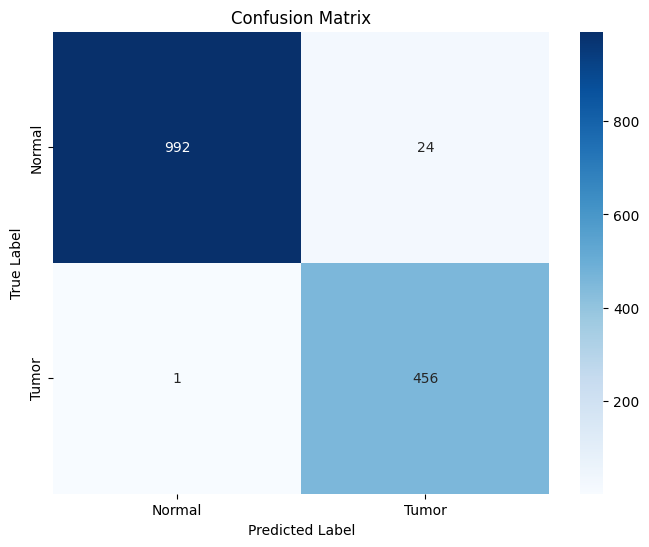

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      1016
       Tumor       0.95      1.00      0.97       457

    accuracy                           0.98      1473
   macro avg       0.97      0.99      0.98      1473
weighted avg       0.98      0.98      0.98      1473



In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model=tf.keras.models.load_model('/content/drive/MyDrive/models/best_model_epoch_21.h5')
# Step 1: Get True Labels
true_labels = valid_generator.classes  # Actual labels from the validation generator
class_names = list(valid_generator.class_indices.keys())  # Class names

# Step 2: Predict on Validation Set
pred_probs = model.predict(valid_generator)  # Get probabilities
pred_labels = np.argmax(pred_probs, axis=1)  # Convert to class labels

# Step 3: Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Print Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))
